### Q1: Using your laptop/desktop webcam, create a video that contains the background for the
### first few seconds followed by your entry in the video.

In [1]:
import cv2

In [2]:
a = cv2.VideoCapture(0)
img_array = []
while True:
    check, frame = a.read()
    
    height, width, layers = frame.shape
    size = (width,height)
    img_array.append(frame)
 
 
    out = cv2.VideoWriter('my_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    
    
    cv2.imshow("Image",frame)
    key=cv2.waitKey(1)
    if key==ord('q'):
        break

out.release()
a.release()
cv2.destroyAllWindows()

### Q2:  Perform Bacground Substitution on the images of the provided dataset

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sys
import cv2

In [11]:
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return(mean,variance)

### Classify images into foreground and background pixels using a Chebyshev inequality based classifier

In [12]:
def ForegroundDetection(img_file,mean,variance,lmda):
    img = cv2.imread(img_file)
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

### Reduce the image noise using a voting scheme

In [13]:
def Voting(rI,eta,m,n):
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n: # Threshold
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

### Update the mean and variance images using a weighted average scheme

In [14]:
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:]+alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:]+alpha*d_2[i,j,:])
                var_upd[i,j,:] =np.clip(var_upd[i,j,:],a_min = 9, a_max = None)
    return(mean_upd,var_upd)

In [15]:
def Background_Substraction(img_dir,lmda,eta,m,n,alpha):
    img_file_name = os.listdir(img_dir)  
    initImage = os.path.join(img_dir,img_file_name[0]) 
    mean, variance = initBackground(initImage)
    
    for i in range(7,11):
        img_path = os.path.join(img_dir,img_file_name[i]) 
        fig,ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)  
                                                                        
        ax[1].imshow(cI,cmap = "gray")
        
        img = cv2.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()        
    return(mean,variance)

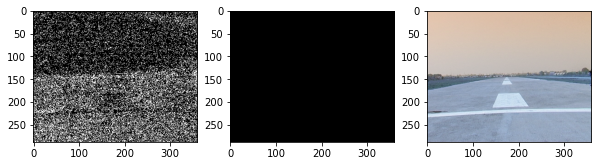

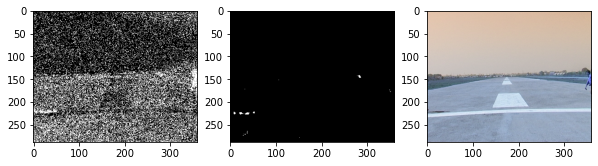

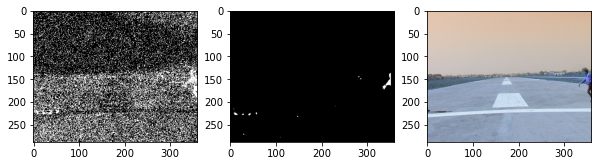

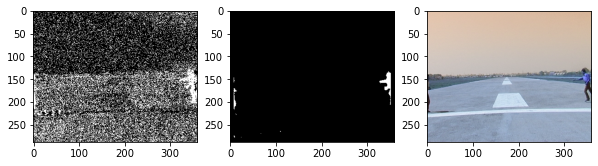

In [16]:
mean, variance = Background_Substraction("./AirStripVideo/Images",0.8,0.7,8,8,0.8) 

#### We'll update the Background_Substitution function to see the effect of change of lambda and eta parameters on a single image

In [18]:
def Background_Substraction2(img_dir,lmda,eta,m,n,alpha):
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(20,21):
        img_path = os.path.join(img_dir,img_file_name[i])
        fig,ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)
        ax[1].imshow(cI,cmap = "gray")
        
        img = cv2.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()
    return(mean,variance)

#### For eta = 0.7, lambda = 0.7

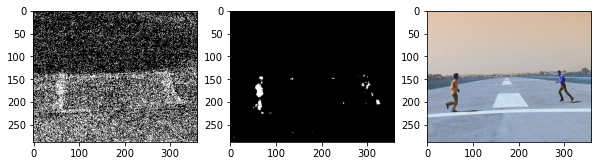

In [19]:
mean, variance = Background_Substraction2("./AirStripVideo/Images",0.7,0.7,8,8,0.8)

#### For eta = 0.9, lambda = 0.7

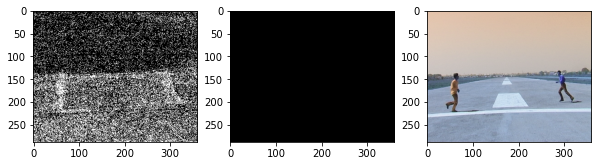

In [20]:
mean, variance = Background_Substraction2("./AirStripVideo/Images",0.7,0.9,8,8,0.8)

#### For eta = 0.7, lambda = 0.9

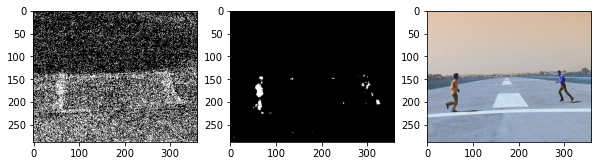

In [21]:
mean, variance = Background_Substraction2("./AirStripVideo/Images",0.9,0.7,8,8,0.8)